In [3]:
#csvファイルを読み込む
import pandas as pd

# ファイルパス（適宜変更してください）
file_path = "Japanese_energy_data.csv"

# 読み込み
df = pd.read_csv(file_path)

# 先頭5行を確認
print(df.head())

# データの概要
print(df.info())




   year   石炭   石油 天然ガス 水力 原子力     薪炭 再エネ  Unnamed: 8 CO2（百万トン）  Unnamed: 10  \
0  1880  567  553    0  0   0  3,495   0         NaN        22          NaN   
1  1881  602  308    0  0   0  3,235   0         NaN        23          NaN   
2  1882  596  728    0  0   0  3,115   0         NaN        24          NaN   
3  1883  639   84    0  0   0  2,878   0         NaN        26          NaN   
4  1884  715  644    0  0   0  2,710   0         NaN        28          NaN   

   modern_energy_rate  
0            0.242687  
1            0.219542  
2            0.298265  
3            0.200778  
4            0.333989  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                137 non-null    int64  
 1   石炭                  137 non-null    object 
 2   石油                  137 non-null    object 
 3   天然ガス                137 no


=== Japan: Fitted parameters (a=1 fixed) ===
b = 3.65181 (SE=0.211, 95% CI [3.23376, 4.06986])
c = 0.0735215 (SE=0.00236, 95% CI [0.0688521, 0.0781908])

k = 0.073521,  x* = 1897.62


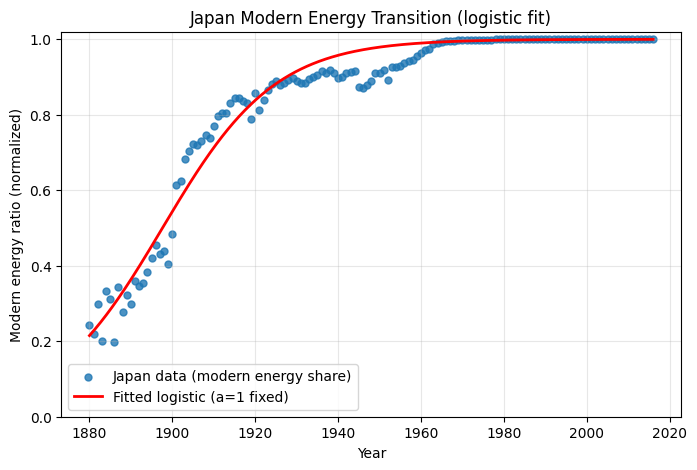

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t
import pandas as pd

# --- データ読込 ---
file_path = "Japanese_energy_data.csv"
df = pd.read_csv(file_path)

# 数値化（文字列中のカンマを除去）
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float, errors='ignore')

years = df["year"].values.astype(float)
vals = df["modern_energy_rate"].values.astype(float)

# --- a=1固定ロジスティック関数 ---
def logistic_fixed(x, b, c):
    x0 = x.min()
    return 1 / (1 + b * np.exp(-c * (x - x0)))

# --- 初期値と境界 ---
p0 = [1.0, 0.03]
bounds = ([0.0, 1e-4], [1e6, 1.0])

# --- フィット ---
popt, pcov = curve_fit(
    logistic_fixed,
    years,
    vals,
    p0=p0,
    bounds=bounds,
    maxfev=200000
)

b, c = popt
perr = np.sqrt(np.diag(pcov))

# --- 派生量 ---
x0 = years.min()
k = c
lnb = np.log(b)
x_star = x0 + lnb / c

# --- 信頼区間 ---
dof = max(len(years) - len(popt), 1)
tval = t.ppf(1 - 0.05/2, dof)

print("\n=== Japan: Fitted parameters (a=1 fixed) ===")
for name, val, se in zip(["b", "c"], popt, perr):
    ci_low = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g} (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")

print(f"\nk = {k:.6f},  x* = {x_star:.2f}")

# --- プロット ---
t_grid = np.linspace(years.min(), years.max(), 600)
yhat = logistic_fixed(t_grid, *popt)

plt.figure(figsize=(8,5))
plt.scatter(years, vals, s=25, alpha=0.8, label="Japan data (modern energy share)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic (a=1 fixed)")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized)")
plt.title("Japan Modern Energy Transition (logistic fit)")
plt.ylim(0, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# normalized by max value

最大値 = 1.000, 到達年 = 2012

=== Japan: Fitted parameters (normalized by max, a free) ===
a = 0.978054 (SE=0.00498, 95% CI [0.968206, 0.987902])
b = 3.9415 (SE=0.239, 95% CI [3.46782, 4.41517])
c = 0.0809355 (SE=0.00293, 95% CI [0.0751401, 0.0867309])

k = 0.080935,  x* = 1896.95


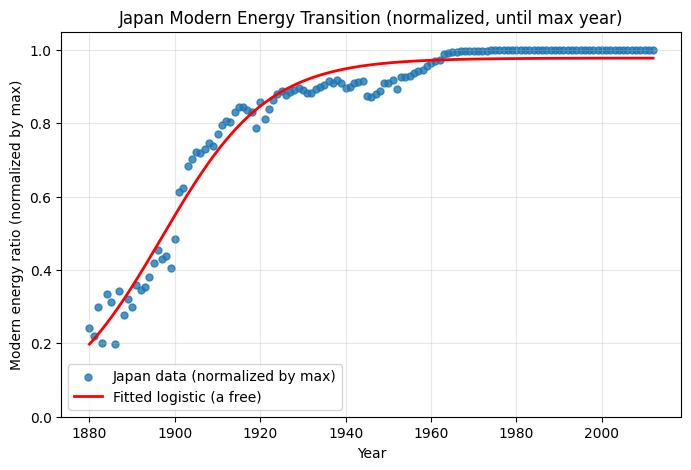

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t
import pandas as pd

# --- データ読み込み ---
file_path = "Japanese_energy_data.csv"
df = pd.read_csv(file_path)

# 数値化（カンマ除去）
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float, errors='ignore')

years = df["year"].values.astype(float)
vals_raw = df["modern_energy_rate"].values.astype(float)

# --- 最大値で正規化 ---
max_val = np.nanmax(vals_raw)
vals = vals_raw / max_val

# --- 最大値到達点まで抽出 ---
imax = np.nanargmax(vals_raw)
year_cut = years[:imax+1]
vals_cut = vals[:imax+1]

print(f"最大値 = {max_val:.3f}, 到達年 = {years[imax]:.0f}")

# --- ロジスティック関数（a自由） ---
def logistic_free(x, a, b, c):
    x0 = x.min()
    return a / (1 + b * np.exp(-c * (x - x0)))

# 初期値と境界
p0 = [1.0, 1.0, 0.03]
bounds = ([0.5, 0.0, 1e-4], [1.5, 1e6, 1.0])

# --- フィット ---
popt, pcov = curve_fit(
    logistic_free,
    year_cut,
    vals_cut,
    p0=p0,
    bounds=bounds,
    maxfev=200000
)
a, b, c = popt
perr = np.sqrt(np.diag(pcov))

# --- 派生量 ---
x0 = year_cut.min()
k = c
lnb = np.log(b)
x_star = x0 + lnb / c

# --- 信頼区間 ---
dof = max(len(year_cut) - len(popt), 1)
tval = t.ppf(1 - 0.05/2, dof)

print("\n=== Japan: Fitted parameters (normalized by max, a free) ===")
for name, val, se in zip(["a","b","c"], popt, perr):
    ci_low = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g} (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")

print(f"\nk = {k:.6f},  x* = {x_star:.2f}")

# --- プロット ---
t_grid = np.linspace(year_cut.min(), year_cut.max(), 600)
yhat = logistic_free(t_grid, *popt)

plt.figure(figsize=(8,5))
plt.scatter(year_cut, vals_cut, s=25, alpha=0.8, label="Japan data (normalized by max)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic (a free)")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized by max)")
plt.title("Japan Modern Energy Transition (normalized, until max year)")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


最大値 = 1.000, 到達年 = 2012

=== Japan: Fitted parameters (a free) ===
a = 0.978054 (SE=0.00498, 95% CI [0.968206, 0.987902])
b = 3.9415 (SE=0.239, 95% CI [3.46782, 4.41517])
c = 0.0809355 (SE=0.00293, 95% CI [0.0751401, 0.0867309])

--- Converted to standard logistic form ---
a = 0.978054
k = 0.080935
m = 1896.95


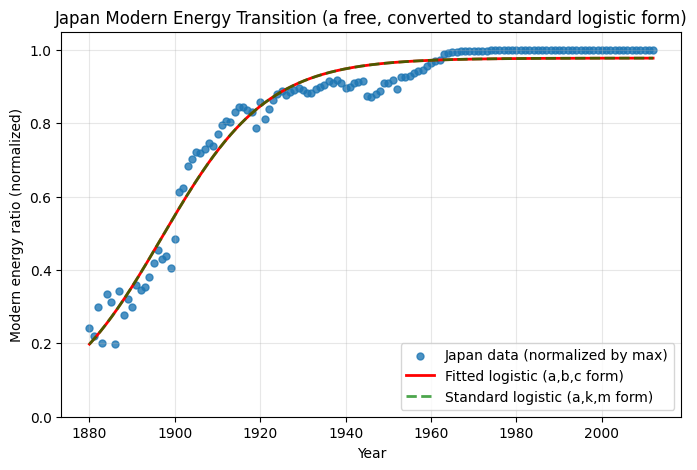

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t
import pandas as pd

# --- データ読み込み ---
file_path = "Japanese_energy_data.csv"
df = pd.read_csv(file_path)

# 数値化（カンマ除去）
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float, errors='ignore')

years = df["year"].values.astype(float)
vals_raw = df["modern_energy_rate"].values.astype(float)

# --- 最大値で正規化 ---
max_val = np.nanmax(vals_raw)
vals = vals_raw / max_val

# --- 最大値到達点まで抽出 ---
imax = np.nanargmax(vals_raw)
year_cut = years[:imax+1]
vals_cut = vals[:imax+1]

print(f"最大値 = {max_val:.3f}, 到達年 = {years[imax]:.0f}")

# --- ロジスティック関数（a自由） ---
def logistic_free(x, a, b, c):
    x0 = x.min()
    return a / (1 + b * np.exp(-c * (x - x0)))

# 初期値と境界
p0 = [1.0, 1.0, 0.03]
bounds = ([0.5, 0.0, 1e-4], [1.5, 1e6, 1.0])

# --- フィット ---
popt, pcov = curve_fit(
    logistic_free,
    year_cut,
    vals_cut,
    p0=p0,
    bounds=bounds,
    maxfev=200000
)
a, b, c = popt
perr = np.sqrt(np.diag(pcov))

# --- 派生量 ---
x0 = year_cut.min()
k = c
lnb = np.log(b)
m = x0 + lnb / c   # 標準形での転換点

# --- 信頼区間 ---
dof = max(len(year_cut) - len(popt), 1)
tval = t.ppf(1 - 0.05/2, dof)

print("\n=== Japan: Fitted parameters (a free) ===")
for name, val, se in zip(["a","b","c"], popt, perr):
    ci_low = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g} (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")

print(f"\n--- Converted to standard logistic form ---")
print(f"a = {a:.6f}")
print(f"k = {k:.6f}")
print(f"m = {m:.2f}")

# --- 標準形（a,k,m形式）の関数 ---
def logistic_standard(x, a, k, m):
    return a / (1 + np.exp(-k * (x - m)))

# --- プロット ---
t_grid = np.linspace(year_cut.min(), year_cut.max(), 600)
yhat_free = logistic_free(t_grid, *popt)
yhat_std = logistic_standard(t_grid, a, k, m)

plt.figure(figsize=(8,5))
plt.scatter(year_cut, vals_cut, s=25, alpha=0.8, label="Japan data (normalized by max)")
plt.plot(t_grid, yhat_free, "r-", lw=2, label="Fitted logistic (a,b,c form)")
plt.plot(t_grid, yhat_std, "g--", lw=2, alpha=0.7, label="Standard logistic (a,k,m form)")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized)")
plt.title("Japan Modern Energy Transition (a free, converted to standard logistic form)")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# fix a to 1

最大値 = 1.000, 到達年 = 2012

=== Japan: Fitted parameters (a=1 fixed, until max year) ===
b = 3.65225  (95% CI [3.22772, 4.07678])
c = 0.0735327  (95% CI [0.068791, 0.0782744])

Converted to standard logistic form:
k = 0.073533
m = 1897.62


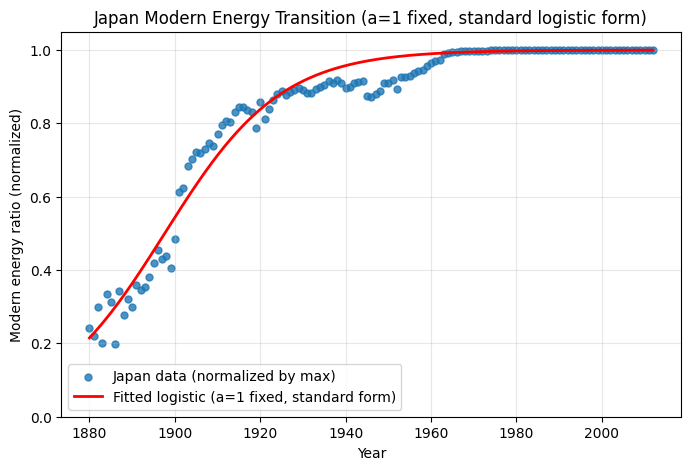

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t
import pandas as pd

# --- データ読み込み ---
file_path = "Japanese_energy_data.csv"
df = pd.read_csv(file_path)

# 数値化（カンマ除去）
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float, errors='ignore')

years = df["year"].values.astype(float)
vals_raw = df["modern_energy_rate"].values.astype(float)

# --- 最大値で正規化 ---
max_val = np.nanmax(vals_raw)
vals = vals_raw / max_val

# --- 最大値到達点まで抽出 ---
imax = np.nanargmax(vals_raw)
year_cut = years[:imax+1]
vals_cut = vals[:imax+1]

print(f"最大値 = {max_val:.3f}, 到達年 = {years[imax]:.0f}")

# --- a=1固定のロジスティック関数 ---
def logistic_fixed(x, b, c):
    x0 = x.min()
    return 1 / (1 + b * np.exp(-c * (x - x0)))

# 初期値と境界
p0 = [1.0, 0.03]
bounds = ([0.0, 1e-4], [1e6, 1.0])

# --- フィット ---
popt, pcov = curve_fit(
    logistic_fixed,
    year_cut,
    vals_cut,
    p0=p0,
    bounds=bounds,
    maxfev=200000
)
b, c = popt
perr = np.sqrt(np.diag(pcov))

# --- 標準形パラメータに変換 ---
x0 = year_cut.min()
k = c
m = x0 + np.log(b) / c  # 50%転換点

# --- 信頼区間 ---
dof = max(len(year_cut) - len(popt), 1)
tval = t.ppf(1 - 0.05/2, dof)
ci_b = (b - tval * perr[0], b + tval * perr[0])
ci_c = (c - tval * perr[1], c + tval * perr[1])

print("\n=== Japan: Fitted parameters (a=1 fixed, until max year) ===")
print(f"b = {b:.6g}  (95% CI [{ci_b[0]:.6g}, {ci_b[1]:.6g}])")
print(f"c = {c:.6g}  (95% CI [{ci_c[0]:.6g}, {ci_c[1]:.6g}])")
print(f"\nConverted to standard logistic form:")
print(f"k = {k:.6f}")
print(f"m = {m:.2f}")

# --- 標準形の関数 ---
def logistic_standard(x, k, m):
    return 1 / (1 + np.exp(-k * (x - m)))

# --- プロット ---
t_grid = np.linspace(year_cut.min(), year_cut.max(), 600)
yhat_std = logistic_standard(t_grid, k, m)

plt.figure(figsize=(8,5))
plt.scatter(year_cut, vals_cut, s=25, alpha=0.8, label="Japan data (normalized by max)")
plt.plot(t_grid, yhat_std, "r-", lw=2, label="Fitted logistic (a=1 fixed, standard form)")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized)")
plt.title("Japan Modern Energy Transition (a=1 fixed, standard logistic form)")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


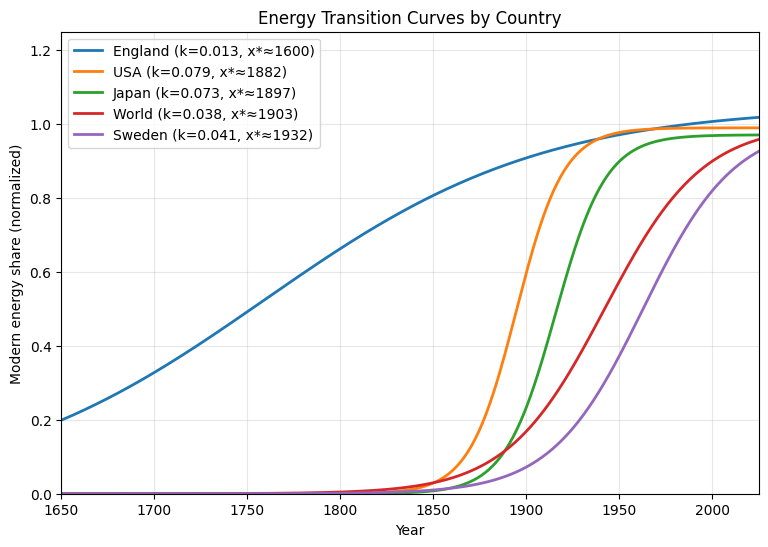

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- ロジスティック関数 ---
def logistic(a, b, k, x0, x):
    return a / (1 + b * np.exp(-k * (x - x0)))

# --- 各国パラメータ ---
params = {
    "England": {"a": 1.048, "b": 8.3, "k": 0.0133, "x0": 1600},
    "USA":     {"a": 0.990, "b": 2.7, "k": 0.0785, "x0": 1882},
    "Japan":   {"a": 0.971, "b": 3.94,"k": 0.0735, "x0": 1897},
    "World":   {"a": 1.000, "b": 4.4, "k": 0.0379, "x0": 1903},
    "Sweden":  {"a": 1.000, "b": 3.5, "k": 0.0407, "x0": 1932},
}

# --- プロット範囲 ---
x = np.linspace(1650, 2025, 600)

plt.figure(figsize=(9,6))

for country, p in params.items():
    y = logistic(p["a"], p["b"], p["k"], p["x0"], x)
    plt.plot(x, y, lw=2, label=f"{country} (k={p['k']:.3f}, x*≈{p['x0']})")

plt.xlabel("Year")
plt.ylabel("Modern energy share (normalized)")
plt.title("Energy Transition Curves by Country")
plt.ylim(0, 1.25)
plt.xlim(1650, 2025)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


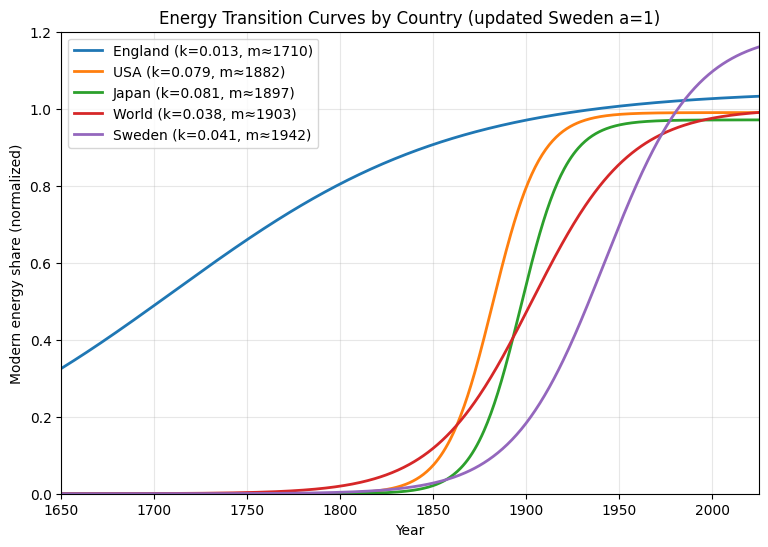

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def logistic(a, k, m, x):
    return a / (1 + np.exp(-k * (x - m)))

params = {
    "England": {"a": 1.048, "k": 0.0133, "m": 1710},
    "USA":     {"a": 0.990, "k": 0.0785, "m": 1882},
    "Japan":   {"a": 0.971, "k": 0.0809, "m": 1897},
    "World":   {"a": 1.000, "k": 0.0379, "m": 1903},
    "Sweden":  {"a": 1.2, "k": 0.0407, "m": 1942},  # a=1固定版
}

x = np.linspace(1650, 2025, 600)
plt.figure(figsize=(9,6))

for country, p in params.items():
    y = logistic(p["a"], p["k"], p["m"], x)
    plt.plot(x, y, lw=2, label=f"{country} (k={p['k']:.3f}, m≈{p['m']})")

plt.xlabel("Year")
plt.ylabel("Modern energy share (normalized)")
plt.title("Energy Transition Curves by Country (updated Sweden a=1)")
plt.ylim(0, 1.2)
plt.xlim(1650, 2025)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


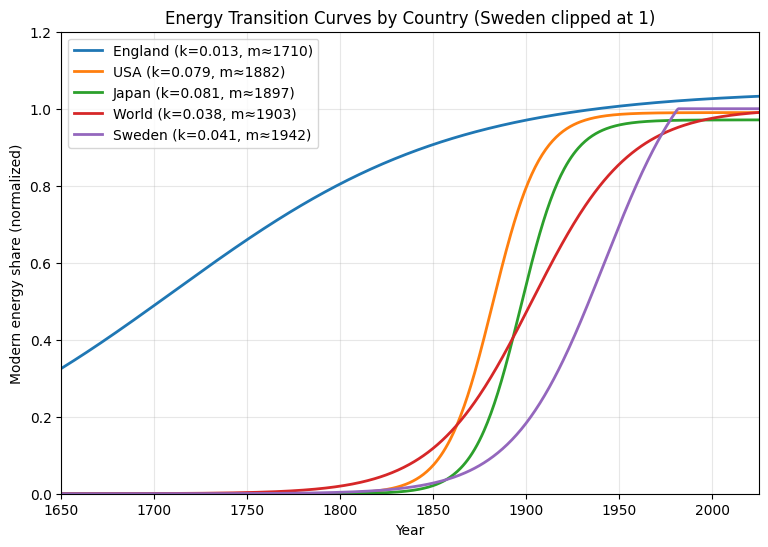

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def logistic(a, k, m, x):
    """標準ロジスティック関数"""
    return a / (1 + np.exp(-k * (x - m)))

# --- 各国パラメータ ---
params = {
    "England": {"a": 1.048, "k": 0.0133, "m": 1710},
    "USA":     {"a": 0.990, "k": 0.0785, "m": 1882},
    "Japan":   {"a": 0.971, "k": 0.0809, "m": 1897},
    "World":   {"a": 1.000, "k": 0.0379, "m": 1903},
    # Sweden: a=1.2 のまま、ただし値が1を超えたら1にクリップ
    "Sweden":  {"a": 1.2, "k": 0.0407, "m": 1942},
}

x = np.linspace(1650, 2025, 600)
plt.figure(figsize=(9,6))

for country, p in params.items():
    y = logistic(p["a"], p["k"], p["m"], x)
    
    # --- Sweden だけ、1 を上限にクリップ ---
    if country == "Sweden":
        y = np.minimum(1.0, y)
    
    plt.plot(x, y, lw=2, label=f"{country} (k={p['k']:.3f}, m≈{p['m']})")

plt.xlabel("Year")
plt.ylabel("Modern energy share (normalized)")
plt.title("Energy Transition Curves by Country (Sweden clipped at 1)")
plt.ylim(0, 1.2)
plt.xlim(1650, 2025)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


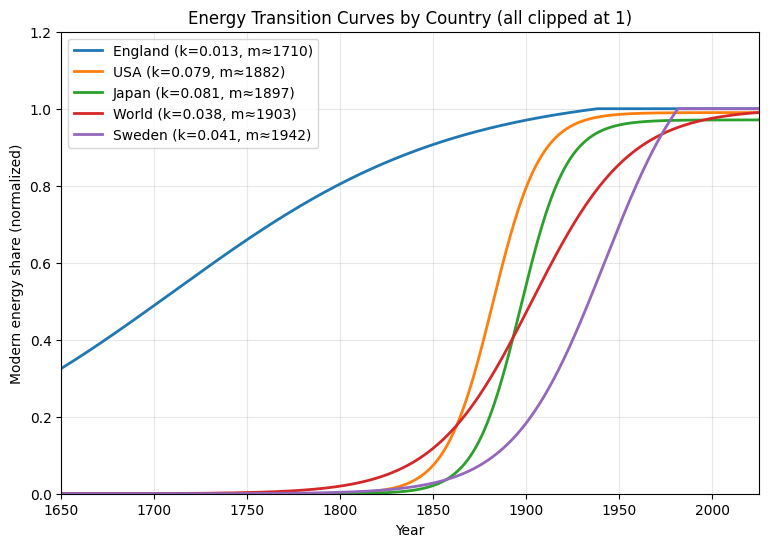

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def logistic(a, k, m, x):
    """標準ロジスティック関数"""
    return a / (1 + np.exp(-k * (x - m)))

# --- 各国パラメータ（aは自由推定値） ---
params = {
    "England": {"a": 1.048, "k": 0.0133, "m": 1710},
    "USA":     {"a": 0.990, "k": 0.0785, "m": 1882},
    "Japan":   {"a": 0.971, "k": 0.0809, "m": 1897},
    "World":   {"a": 1.000, "k": 0.0379, "m": 1903},
    "Sweden":  {"a": 1.200, "k": 0.0407, "m": 1942},
}

x = np.linspace(1650, 2025, 600)
plt.figure(figsize=(9,6))

for country, p in params.items():
    # ロジスティック値を計算
    y = logistic(p["a"], p["k"], p["m"], x)
    # --- すべての国に対して、1を超える値は1にクリップ ---
    y = np.minimum(1.0, y)
    
    plt.plot(x, y, lw=2, label=f"{country} (k={p['k']:.3f}, m≈{p['m']})")

plt.xlabel("Year")
plt.ylabel("Modern energy share (normalized)")
plt.title("Energy Transition Curves by Country (all clipped at 1)")
plt.ylim(0, 1.2)
plt.xlim(1650, 2025)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
